# Predicting BMI from psychological variables - Classification

In [13]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.utils.multiclass import unique_labels

import tensorflow
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [15]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.set_random_seed(RANDOM_SEED)

In [16]:
with open('../data/X_paper.pkl', 'rb') as f:
    X = pickle.load(f)

with open('../data/y_paper.pkl', 'rb') as f:
    y = pickle.load(f)

In [17]:
X

array([[  22,  110,  101,  222,    0],
       [  21,  102,  100,  220,    0],
       [  21,  102,  100,  212,    0],
       ...,
       [ 111,  122,  112, 1120,    0],
       [ 111,  122,  112, 1120,    0],
       [ 111,  122,  112, 1112,    0]])

In [18]:
X = np.concatenate((X[:250], X[750:1000], X[1500:]), axis=0)
y = np.concatenate((y[:250], y[750:1000], y[1500:]), axis=0)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

## Model Spotting

In [20]:
# Test options and evaluation metric
num_folds = 4
seed = 42
scoring = 'f1_macro'


In [21]:
y_train

array([5, 1, 4, 4, 5, 4, 5, 1, 4, 0, 5, 1, 4, 0, 4, 0, 4, 4, 1, 0, 0, 4,
       0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 1,
       5, 5, 0, 4, 1, 4, 5, 1, 0, 0, 1, 4, 0, 4, 0, 4, 1, 1, 1, 4, 1, 0,
       4, 0, 4, 4, 4, 4, 4, 0, 0, 4, 4, 5, 0, 5, 4, 0, 4, 4, 1, 0, 0, 5,
       0, 4, 4, 4, 4, 5, 4, 1, 1, 1, 5, 0, 1, 4, 1, 1, 4, 1, 4, 4, 4, 0,
       5, 4, 4, 4, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 4, 4, 4, 1, 4, 0, 1, 4,
       5, 1, 0, 0, 5, 0, 1, 4, 0, 4, 1, 4, 4, 0, 1, 4, 4, 4, 0, 5, 4, 0,
       0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 4, 0, 4, 4, 4, 5, 0, 0, 5, 1, 4, 5,
       0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 5, 4, 0, 0, 4, 4, 0, 0, 0, 4,
       1, 4, 1, 5, 0, 4, 5, 0, 4, 1, 4, 1, 4, 4, 4, 1, 5, 0, 5, 0, 1, 0,
       4, 4, 5, 4, 0, 4, 0, 4, 1, 4, 4, 0, 1, 0, 5, 4, 5, 4, 4, 4, 4, 0,
       0, 0, 4, 4, 1, 1, 0, 0, 4, 0, 4, 1, 0, 1, 5, 5, 4, 4, 4, 4, 0, 1,
       4, 1, 4, 5, 4, 1, 0, 1, 4, 0, 1, 0, 4, 4, 5, 4, 1, 1, 4, 4, 4, 0,
       1, 1, 4, 4, 0, 1, 4, 1, 1, 1, 0, 0, 1, 4, 4,

In [22]:
# Spot-Check Algorithms
models = []
'''
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma='auto', random_state=seed)))
models.append(('MLP' , MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=seed)))
models.append(('AB',  AdaBoostClassifier(random_state=seed, n_estimators = 50)))
models.append(('GB', GradientBoostingClassifier(random_state=seed, n_estimators = 50)))
models.append(('RF',  RandomForestClassifier(random_state=seed, n_estimators = 50)))
models.append(('ET',  ExtraTreesClassifier(random_state=seed, n_estimators = 50)))
'''
models.append(('KNN' , )
models.append(('CART' , Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier(random_state=seed))])))
models.append(('SVC' , Pipeline([('Scaler', StandardScaler()),('SVC', SVC(gamma='auto', random_state=seed))])))
models.append(('MLP' , Pipeline([('Scaler', StandardScaler()),('MLP', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=seed))])))
models.append(('AB',  Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostClassifier(random_state=seed, n_estimators = 50))])))
models.append(('GB', Pipeline([('Scaler', StandardScaler()),('GB', GradientBoostingClassifier(random_state=seed, n_estimators = 50))])))
models.append(('RF',  Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(random_state=seed, n_estimators = 50))])))
models.append(('ET',  Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesClassifier(random_state=seed, n_estimators = 50))])))



results = []
names = []

In [32]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_cross_test, y_cross_test = X_train.iloc[test_idx], y_train.iloc[test_idx]

        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

KNN - 0,81 0,07
CART - 0,78 0,07
SVC - 0,85 0,07


c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\program files\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

MLP - 0,84 0,05
AB - 0,57 0,15
GB - 0,80 0,06
RF - 0,80 0,07
ET - 0,82 0,06


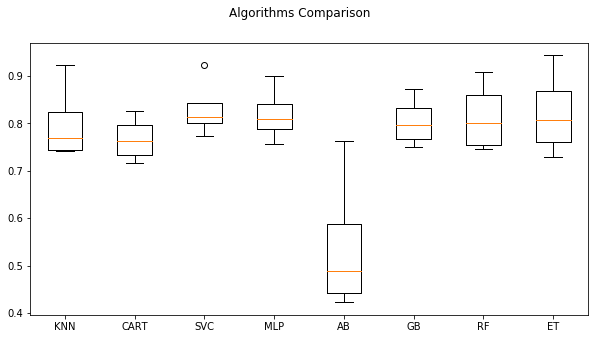

In [27]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi (MLP, GB e RF) su test

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.62      0.69        16
           1       0.25      0.33      0.29         6
           2       0.90      0.93      0.92        30

    accuracy                           0.77        52
   macro avg       0.64      0.63      0.63        52
weighted avg       0.79      0.77      0.77        52



## Summary

Buone prestazioni nell'identificare normal e obese, fatica a distingure gli overweight ma potrebbe derivare semplicemente dal minor numero di esempi.